In [1]:
import biom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gemelli.joint_ctf import joint_ctf
from gemelli.simulations import build_block_model
from gemelli.tempted import tempted_factorize

fig_path = '/Users/bec5786/Desktop/temp_figs/'
%matplotlib inline
data_path = '../ipynb/tutorials/'

In [2]:
def create_sim_data(feature_prefix, n_timepoints, n_subjects,
                    rank=3, hoced=20, hsced=20, 
                    spar=2e3, C_=2e3, overlap=0,
                    num_samples=48, num_features=500):
    
    #create simulated data
    total_samples = n_timepoints * n_subjects
    test_true, test_noise = build_block_model(rank=rank, 
                                              hoced=hoced, hsced=hsced, 
                                              spar=spar, C_=C_, 
                                              num_samples=num_samples,
                                              num_features=num_features,
                                              overlap=overlap, 
                                              mapping_on=False)
    #add feature and sample IDs
    feat_ids = [ '%sF%d' % (feature_prefix, i+1)
                for i in range(test_noise.shape[0])]
    samp_ids = ['sample%d' % (i+1) for i in range(test_noise.shape[1])]
    test_noise = biom.Table(test_noise, feat_ids, samp_ids)
    test_true = biom.Table(test_true, feat_ids, samp_ids)
    
    #create metadata
    mf = pd.DataFrame({'timepoint': np.tile(np.arange(n_timepoints), n_subjects)},
                      index=samp_ids)
    ind_ids = [['ind{}'.format(i+1)] * n_timepoints for i in range(n_subjects)]
    ind_ids = np.concatenate(ind_ids)
    mf['ind_id'] = ind_ids
    #add group ids based on rank
    group_ids = []
    for i in range(rank):
        group_ids.extend(['group{}'.format(i+1)] * (total_samples//rank))
    mf['group'] = group_ids

    return test_true, test_noise, mf

### Test 0

Run Joint-CTF on "real data" + two modalities with constant noise

In [3]:
true_mod1, noise_mod1, mf_mod1 = create_sim_data('mod1', n_timepoints=4, n_subjects=12, 
                                                 rank=2, C_=2e3)
true_mod2, noise_mod2, mf_mod2 = create_sim_data('mod2', n_timepoints=4, n_subjects=12, 
                                                 rank=2, C_=0.8e3)

#softmax (along samples, features sum to 1 per sample) + clr transform (pseudocount of .01) of true data

In [ ]:
from scipy.special import softmax
from skbio.stats.composition import closure

true_mod1_closed = closure(softmax(true_mod1))
true_mod1_clr = clr(true_mod1_closed + #minnon-zero)

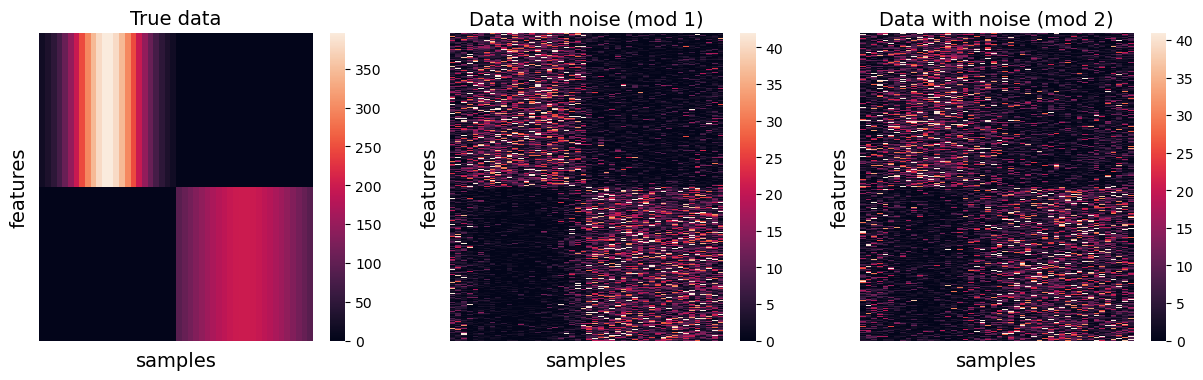

In [4]:
# plot data
fig, axn = plt.subplots(1, 3, figsize=(15, 4))
sns.heatmap(true_mod1.matrix_data.toarray(), robust=True, 
            ax=axn[0], xticklabels=False, yticklabels=False)
sns.heatmap(noise_mod1.matrix_data.toarray(), robust=True, 
            ax=axn[1], xticklabels=False, yticklabels=False)
sns.heatmap(noise_mod2.matrix_data.toarray(), robust=True, 
            ax=axn[2], xticklabels=False, yticklabels=False)
axn[0].set_ylabel('features', color='black', fontsize=14)
axn[0].set_xlabel('samples', color='black', fontsize=14)
axn[0].set_title('True data', color='black', fontsize=14)
axn[1].set_ylabel('features', color='black', fontsize=14)
axn[1].set_xlabel('samples', color='black', fontsize=14)
axn[1].set_title('Data with noise (mod 1)', color='black', fontsize=14)
axn[2].set_ylabel('features', color='black', fontsize=14)
axn[2].set_xlabel('samples', color='black', fontsize=14)
axn[2].set_title('Data with noise (mod 2)', color='black', fontsize=14)
#plt.savefig('{}{}_sim_data_heatmap.png'.format(fig_path, C_mod2),
#            bbox_inches='tight')
plt.show()

In [5]:
#run joint-ctf
(subject_loads, feature_loads, state_loads,
evals, var_explained, feature_covs) = joint_ctf(tables=[noise_mod1, noise_mod2],
                                                sample_metadatas=[mf_mod1, mf_mod2],
                                                modality_ids=['mod1', 'mod2'],
                                                individual_id_column='ind_id',
                                                state_column='timepoint')
print(evals)
print(var_explained.T)

Calculate components for component_1
Reached convergence in 6 iterations
Calculate components for component_2
Reached convergence in 21 iterations
Calculate components for component_3
Reached convergence in 15 iterations
      component_1  component_2  component_3
mod1  3797.243218  1816.214502  1175.818285
mod2  2843.848123  1836.271915  1475.302220
               component_1  component_2  component_3
var_explained     0.527169     0.282474     0.190357


In [6]:
#run joint-ctf
(true_subject_loads, true_feature_loads, 
true_state_loads, true_evals,
true_var_explained, true_feature_covs) = joint_ctf(tables=[true_mod1],
                                                   sample_metadatas=[mf_mod1],
                                                   modality_ids=['mod0'],
                                                   individual_id_column='ind_id',
                                                   state_column='timepoint')
print(true_evals)
print(true_var_explained.T)

Calculate components for component_1
Reached convergence in 2 iterations
Calculate components for component_2
Reached convergence in 4 iterations
Calculate components for component_3
Reached convergence in 4 iterations
       component_1  component_2  component_3
mod0  61829.015512  11941.44944   3507.33426
               component_1  component_2  component_3
var_explained     0.999864     0.000094     0.000042


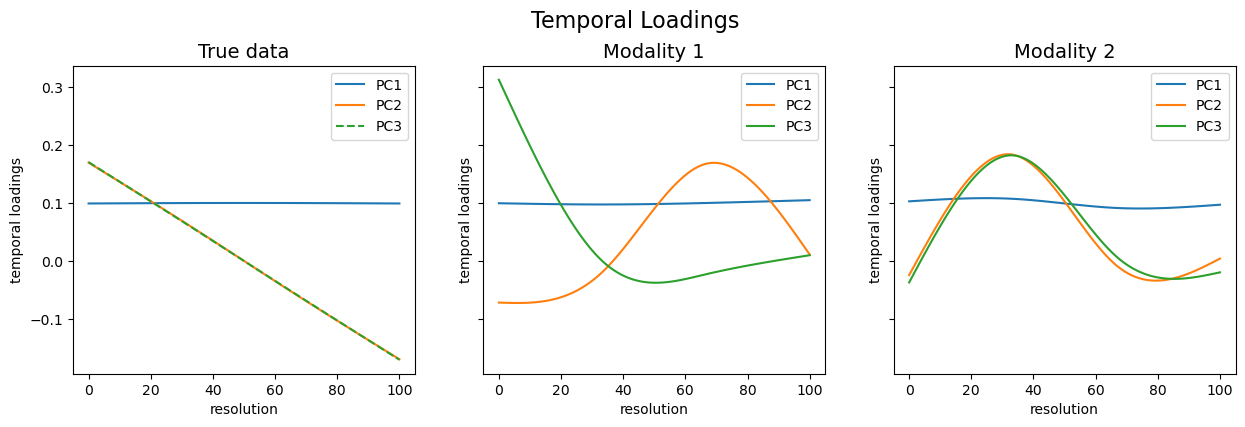

In [7]:
#temporal loadings
fig, axn = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for component,label,ls in zip(['component_1', 'component_2', 'component_3'],
                            ['PC1', 'PC2', 'PC3'], ['-', '-', '--']):
    axn[0].plot(true_state_loads['mod0'][component], 
                label=label, linestyle=ls)
axn[0].legend()
axn[0].set_title('True data', fontsize=14)
axn[1].plot(state_loads['mod1'][['component_1', 'component_2', 'component_3']], 
            label=['PC1', 'PC2', 'PC3'])
axn[1].legend()
axn[1].set_title('Modality 1', fontsize=14)
axn[2].plot(state_loads['mod2'][['component_1', 'component_2', 'component_3']],
            label=['PC1', 'PC2', 'PC3'])
axn[2].legend()
axn[2].set_title('Modality 2', fontsize=14)
plt.suptitle('Temporal Loadings', fontsize=16, y=1.02)
plt.setp(axn, xlabel='resolution', ylabel='temporal loadings')
plt.show()

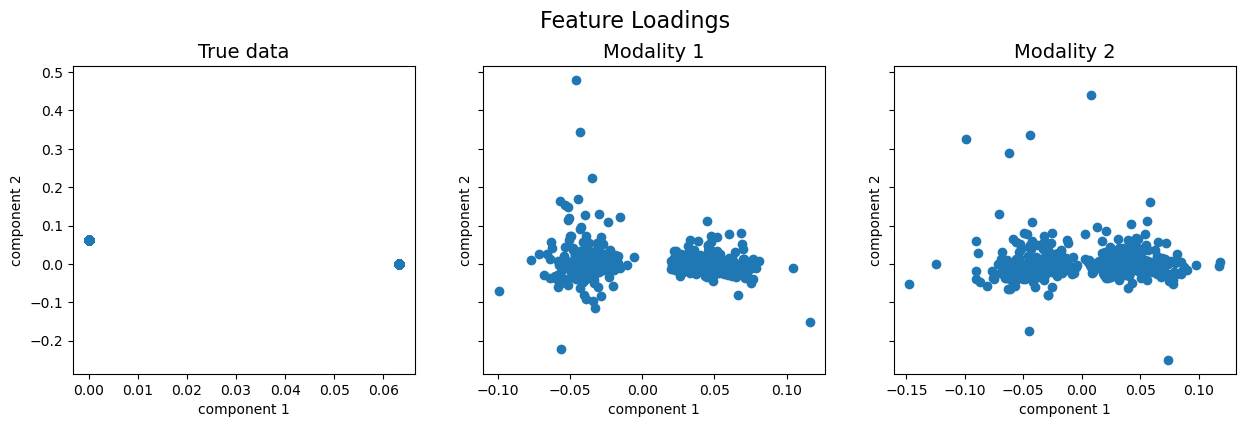

In [8]:
#individual loadings
comp1 = 'component_1'
comp2 = 'component_2'

fig, axn = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
axn[0].scatter(true_feature_loads['mod0'][comp1],
               true_feature_loads['mod0'][comp2])
axn[0].set_title('True data', fontsize=14)
axn[1].scatter(feature_loads['mod1'][comp1],
               feature_loads['mod1'][comp2])
axn[1].set_title('Modality 1', fontsize=14)
axn[2].scatter(feature_loads['mod2'][comp1],
               feature_loads['mod2'][comp2])
axn[2].set_title('Modality 2', fontsize=14)
plt.suptitle('Feature Loadings', fontsize=16, y=1.02)
plt.setp(axn, xlabel=comp1.replace('_', ' '), 
         ylabel=comp2.replace('_', ' '))
plt.show()

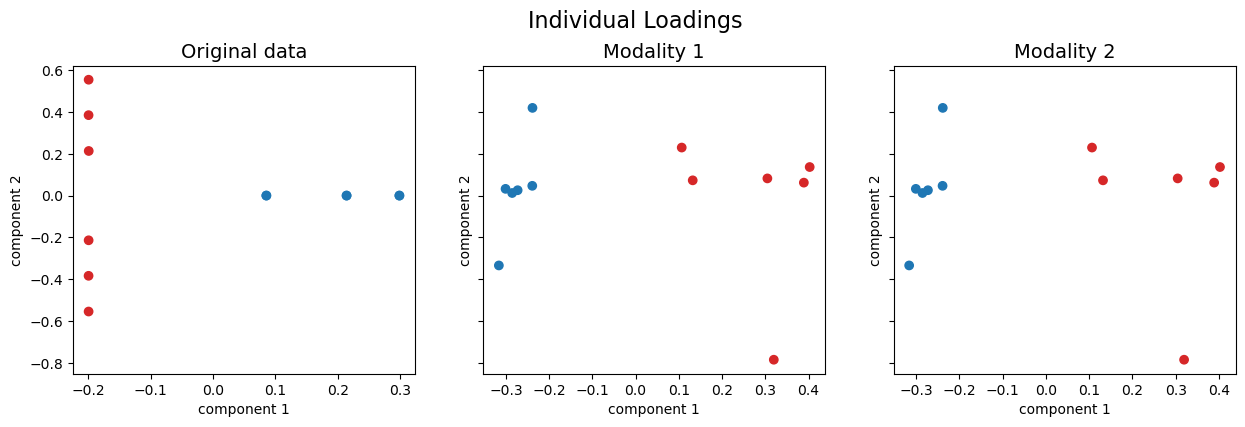

In [9]:
#individual loadings
comp1 = 'component_1'
comp2 = 'component_2'
mf1 = mf_mod1.groupby('ind_id').agg({'group':'first'})
group_colors = {'group1': 'tab:red', 
                'group2': 'tab:blue',
                'group3': 'tab:green'}

fig, axn = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
axn[0].scatter(true_subject_loads['mod0'][comp1],
               true_subject_loads['mod0'][comp2],
               c=mf1['group'].map(group_colors))
axn[0].set_title('Original data', fontsize=14)
axn[1].scatter(subject_loads['mod1'][comp1],
               subject_loads['mod1'][comp2],
               c=mf1['group'].map(group_colors))
axn[1].set_title('Modality 1', fontsize=14)
axn[2].scatter(subject_loads['mod2'][comp1],
               subject_loads['mod2'][comp2],
               c=mf1['group'].map(group_colors))
axn[2].set_title('Modality 2', fontsize=14)
plt.suptitle('Individual Loadings', fontsize=16, y=1.02)
plt.setp(axn, xlabel=comp1.replace('_', ' '), 
         ylabel=comp2.replace('_', ' '))
plt.show()

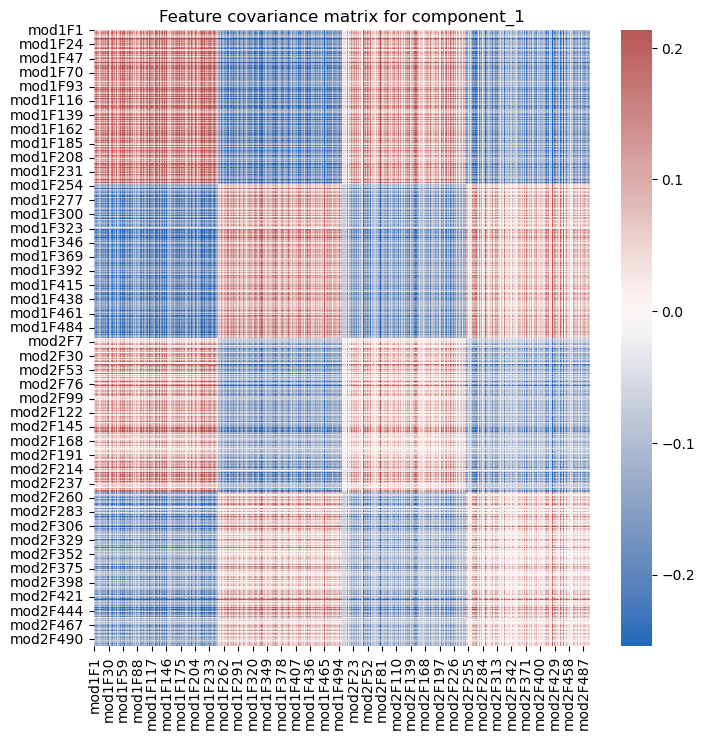

In [10]:
#get feature cov matrix and reorder IDs
feature_order1 = noise_mod1.ids(axis='observation').tolist()
feature_order2 = noise_mod2.ids(axis='observation').tolist()
feature_order = feature_order1 + feature_order2

component = 'component_1'
cov_table = feature_covs[component]
cov_table = cov_table.loc[feature_order, feature_order]

#plot heatmap of feature covariance matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cov_table, robust=True, cmap='vlag', center=0)
plt.title('Feature covariance matrix for {}'.format(component))
plt.show()

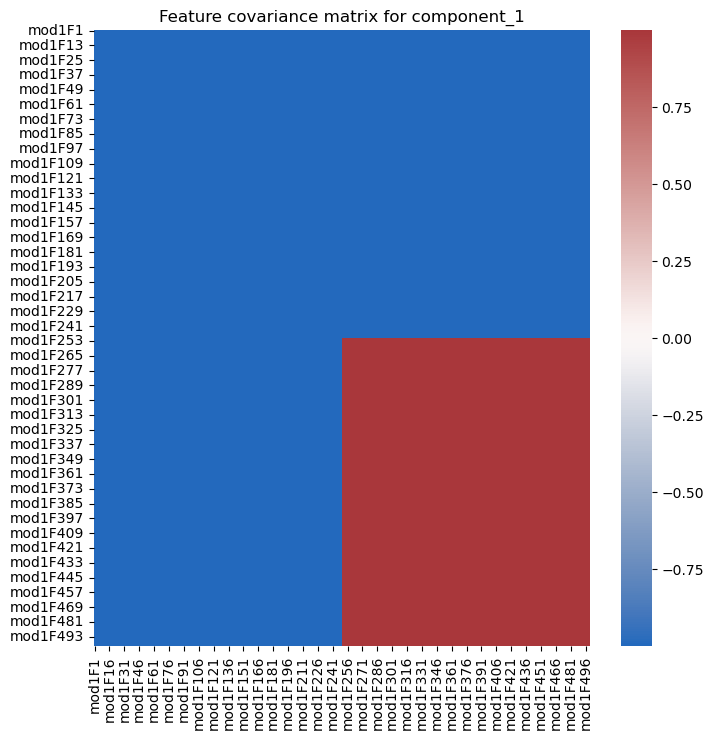

In [11]:
true_order = true_mod1.ids(axis='observation').tolist()
true_cov_table = true_feature_covs[component]
true_cov_table = true_cov_table.loc[true_order, true_order]

plt.figure(figsize=(8, 8))
sns.heatmap(true_cov_table, robust=True, cmap='vlag', center=0)
plt.title('Feature covariance matrix for {}'.format(component))
plt.show()

### Comparison with TEMPTED

In [12]:
tempted_res = tempted_factorize(true_mod1, mf_mod1,
                                'ind_id', 'timepoint')

Prop explained: [0.91969676 0.90815349 0.85873316]
Prop explained argsort: [0 1 2]
Eigenvalues pre-sorting: [61829.01551146 11941.47170427  3507.33264843]
Eigenvalues post-sorting: [61829.01551146 11941.47170427  3507.33264843]


In [13]:
tempted_res_noisy1 = tempted_factorize(noise_mod1, mf_mod1,
                                      'ind_id', 'timepoint')
tempted_res_noisy2 = tempted_factorize(noise_mod2, mf_mod2,
                                      'ind_id', 'timepoint')

Prop explained: [0.16510188 0.05314522 0.04208353]
Prop explained argsort: [0 1 2]
Eigenvalues pre-sorting: [3807.93623771 1306.7400654  1897.51737399]
Eigenvalues post-sorting: [3807.93623771 1306.7400654  1897.51737399]
Prop explained: [0.09157779 0.04491223 0.04354624]
Prop explained argsort: [0 1 2]
Eigenvalues pre-sorting: [2863.29582014 2096.04233253 1202.07282586]
Eigenvalues post-sorting: [2863.29582014 2096.04233253 1202.07282586]


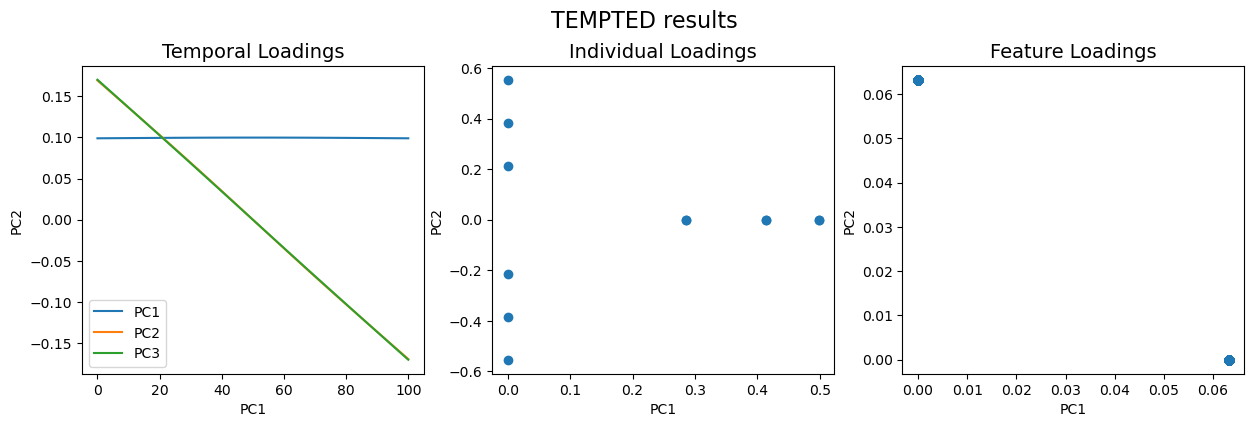

In [14]:
#feature loadings
comp1 = 'PC1'
comp2 = 'PC2'

fig, axn = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
axn[0].plot(tempted_res[1][['PC1', 'PC2', 'PC3']], 
            label=['PC1', 'PC2', 'PC3'])
axn[0].set_title('Temporal Loadings', fontsize=14)
axn[0].legend()
axn[1].scatter(tempted_res[0].samples[comp1],
               tempted_res[0].samples[comp2])
axn[1].set_title('Individual Loadings', fontsize=14)
axn[2].scatter(tempted_res[0].features[comp1],
               tempted_res[0].features[comp2])
axn[2].set_title('Feature Loadings', fontsize=14)
plt.suptitle('TEMPTED results', fontsize=16, y=1.02)
plt.setp(axn, xlabel=comp1.replace('_', ' '), 
         ylabel=comp2.replace('_', ' '))
plt.show()

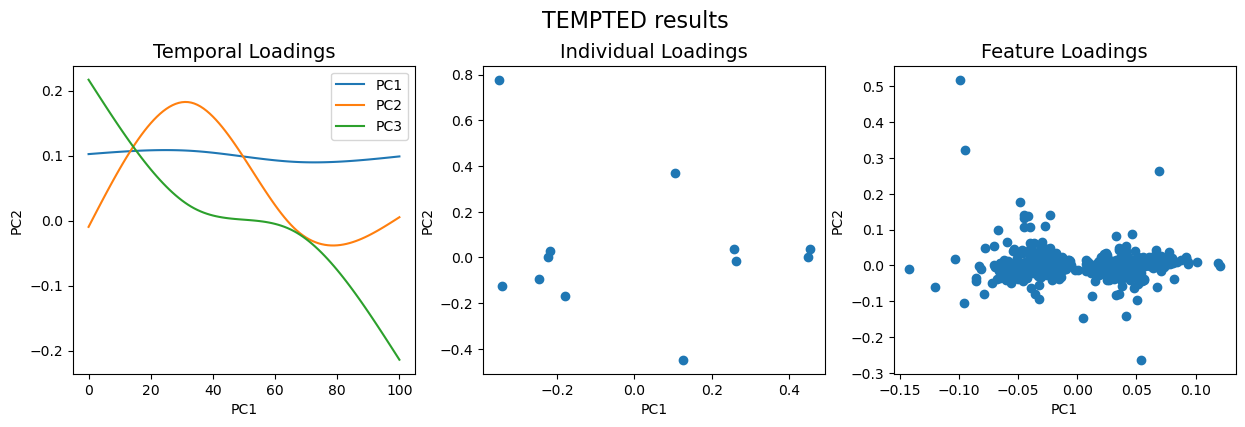

In [15]:
#feature loadings
comp1 = 'PC1'
comp2 = 'PC2'

fig, axn = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
axn[0].plot(tempted_res_noisy2[1][['PC1', 'PC2', 'PC3']], 
            label=['PC1', 'PC2', 'PC3'])
axn[0].set_title('Temporal Loadings', fontsize=14)
axn[0].legend()
axn[1].scatter(tempted_res_noisy2[0].samples[comp1],
               tempted_res_noisy2[0].samples[comp2])
axn[1].set_title('Individual Loadings', fontsize=14)
axn[2].scatter(tempted_res_noisy2[0].features[comp1],
               tempted_res_noisy2[0].features[comp2])
axn[2].set_title('Feature Loadings', fontsize=14)
plt.suptitle('TEMPTED results', fontsize=16, y=1.02)
plt.setp(axn, xlabel=comp1.replace('_', ' '), 
         ylabel=comp2.replace('_', ' '))
plt.show()

In [16]:
#run joint-ctf
(subject_loads, feature_loads, state_loads,
evals, var_explained, feature_covs) = joint_ctf(tables=[noise_mod2],
                                                sample_metadatas=[mf_mod2],
                                                modality_ids=['mod2'],
                                                individual_id_column='ind_id',
                                                state_column='timepoint')
print(evals)
print(var_explained.T)

Calculate components for component_1
Reached convergence in 7 iterations
Calculate components for component_2
Reached convergence in 21 iterations
Calculate components for component_3
Reached convergence in 21 iterations
      component_1  component_2  component_3
mod2  2863.262835  2094.536567  1201.053581
               component_1  component_2  component_3
var_explained     0.490747     0.328721     0.180532


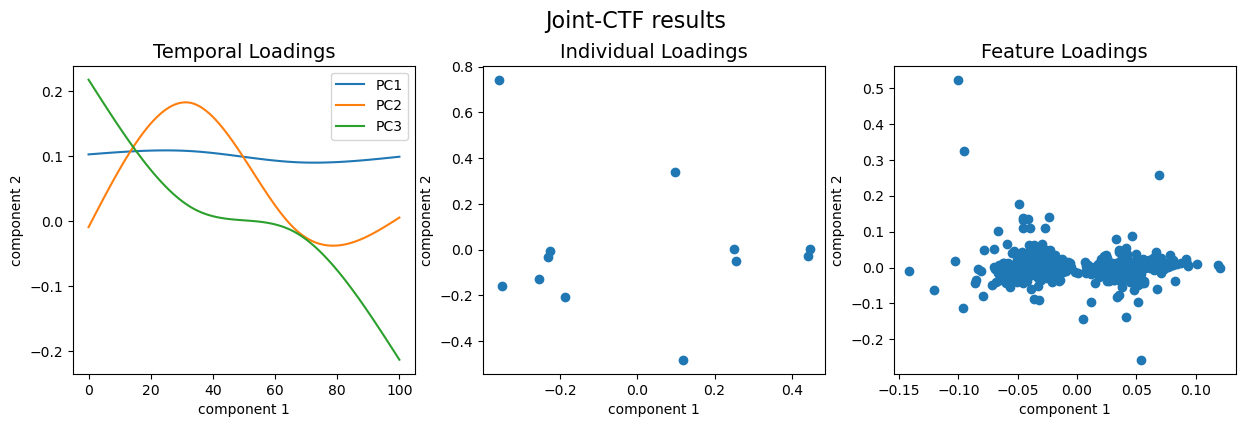

In [17]:
#feature loadings
comp1 = 'component_1'
comp2 = 'component_2'

fig, axn = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
axn[0].plot(state_loads['mod2'][['component_1', 'component_2', 'component_3']], 
            label=['PC1', 'PC2', 'PC3'])
axn[0].set_title('Temporal Loadings', fontsize=14)
axn[0].legend()
axn[1].scatter(subject_loads['mod2'][comp1],
               subject_loads['mod2'][comp2])
axn[1].set_title('Individual Loadings', fontsize=14)
axn[2].scatter(feature_loads['mod2'][comp1],
               feature_loads['mod2'][comp2])
axn[2].set_title('Feature Loadings', fontsize=14)
plt.suptitle('Joint-CTF results', fontsize=16, y=1.02)
plt.setp(axn, xlabel=comp1.replace('_', ' '), 
         ylabel=comp2.replace('_', ' '))
plt.show()

### Test 1

One modality with sine and constant noise patterns

/var/folders/wc/r9njmvn106j5gvr496l3xw65jl16p6/T/ipykernel_36240/2541072825.py:16: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[50.0, 0]'. Picking the first and converting the rest.
  mod1_df = pd.concat([mod1_df, noisy_mod1_df_sub])
/var/folders/wc/r9njmvn106j5gvr496l3xw65jl16p6/T/ipykernel_36240/2541072825.py:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[50.0, 0]'. Picking the first and converting the rest.
  mod1_df = biom.Table(mod1_df.values, mod1_df.index, mod1_df.columns)


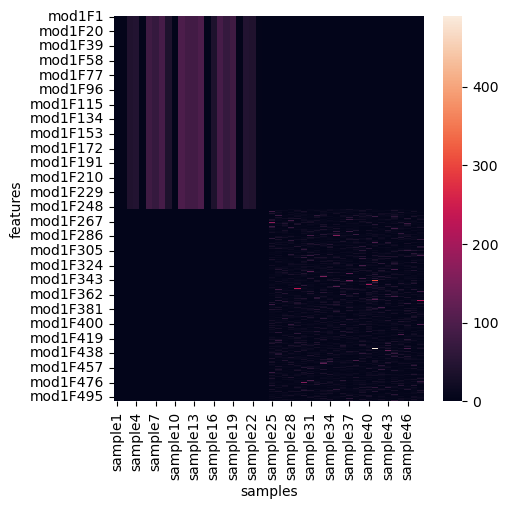

In [18]:
true_mod1, noisy_mod1, mf_mod1 = create_sim_data('mod1', n_timepoints=4, n_subjects=12, 
                                                 rank=2, C_=2e3)

#get half patients and half features
true_mod1_df_sub1 = true_mod1.to_dataframe().iloc[0:250,0:24]
true_mod1_df_sub2 = true_mod1.to_dataframe().iloc[0:250,24:48]
true_mod1_df_sub3 = true_mod1.to_dataframe().iloc[250:500,0:24]
noisy_mod1_df_sub1 = noisy_mod1.to_dataframe().iloc[250:500,24:48]

#apply sine function to all rows
true_mod1_df_sub1 = 50*(1 + true_mod1_df_sub1.apply(np.sin, axis=1))

#now, concat all dataframes
mod1_df = pd.concat([true_mod1_df_sub1, true_mod1_df_sub2], axis=1)
noisy_mod1_df_sub = pd.concat([true_mod1_df_sub3, noisy_mod1_df_sub1], axis=1)
mod1_df = pd.concat([mod1_df, noisy_mod1_df_sub])
mod1_df = biom.Table(mod1_df.values, mod1_df.index, mod1_df.columns)

# plot data
plt.figure(figsize=(5, 5))
sns.heatmap(mod1_df.to_dataframe())
plt.xlabel('samples')
plt.ylabel('features')
plt.show()

In [19]:
#run joint-ctf
(mod1_subject_loads, mod1_feature_loads, 
mod1_state_loads, mod1_subject_lambdas,
mod1_var_explained, mod1_feature_covs) = joint_ctf(tables=[mod1_df],
                                                   sample_metadatas=[mf_mod1],
                                                   modality_ids=['mod1'],
                                                   individual_id_column='ind_id',
                                                   state_column='timepoint')
print(mod1_subject_lambdas)
print(mod1_var_explained.T)

Calculate components for component_1
Reached convergence in 7 iterations
Calculate components for component_2
Reached convergence in 9 iterations
Calculate components for component_3
Reached convergence in 3 iterations
       component_1  component_2  component_3
mod1  10355.543448  4591.689554  4465.003426
               component_1  component_2  component_3
var_explained     0.855832     0.144136     0.000032


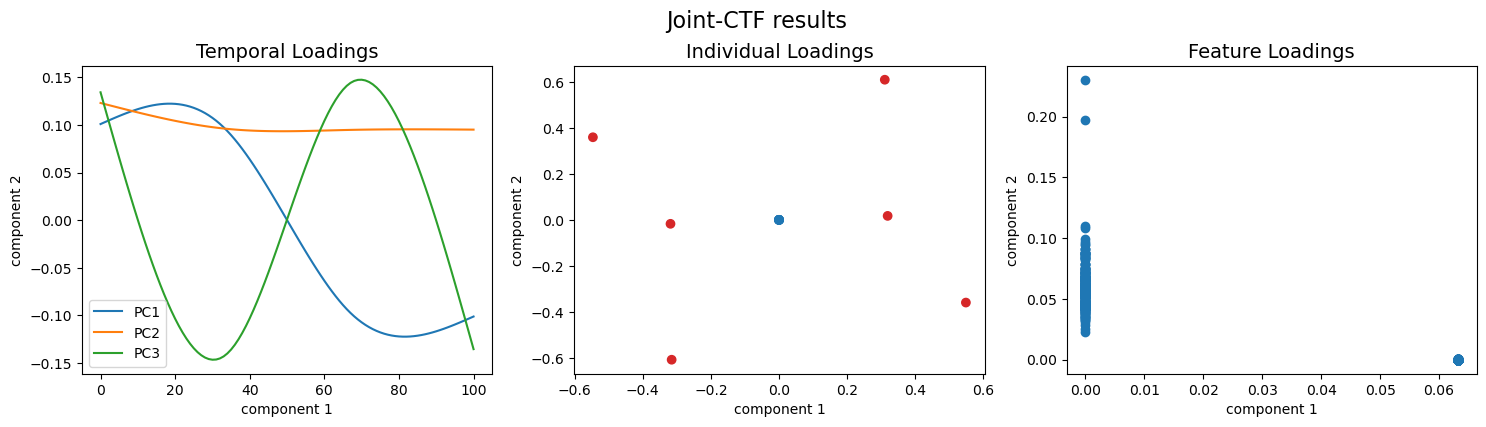

In [20]:
#visualize loadings
comp1 = 'component_1'
comp2 = 'component_2'
mf1 = mf_mod1.groupby('ind_id').agg({'group':'first'})
group_colors = {'group1': 'tab:red', 
                'group2': 'tab:blue',
                'group3': 'tab:green'}

fig, axn = plt.subplots(1, 3, figsize=(18, 4), sharey=False)
axn[0].plot(mod1_state_loads['mod1'][['component_1', 'component_2', 'component_3']], 
            label=['PC1', 'PC2', 'PC3'])
axn[0].set_title('Temporal Loadings', fontsize=14)
axn[0].legend()
axn[1].scatter(mod1_subject_loads['mod1'][comp1],
               mod1_subject_loads['mod1'][comp2],
               c=mf1['group'].map(group_colors))
axn[1].set_title('Individual Loadings', fontsize=14)
axn[2].scatter(mod1_feature_loads['mod1'][comp1],
               mod1_feature_loads['mod1'][comp2])
axn[2].set_title('Feature Loadings', fontsize=14)
plt.suptitle('Joint-CTF results', fontsize=16, y=1.02)
plt.setp(axn, xlabel=comp1.replace('_', ' '), 
         ylabel=comp2.replace('_', ' '))
plt.show()

/var/folders/wc/r9njmvn106j5gvr496l3xw65jl16p6/T/ipykernel_36240/3293060963.py:14: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[50.0, 0]'. Picking the first and converting the rest.
  mod1_df = pd.concat([mod1_df, true_mod1_df_sub3])
/var/folders/wc/r9njmvn106j5gvr496l3xw65jl16p6/T/ipykernel_36240/3293060963.py:15: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[50.0, 0]'. Picking the first and converting the rest.
  mod1_df = biom.Table(mod1_df.values, mod1_df.index, mod1_df.columns)


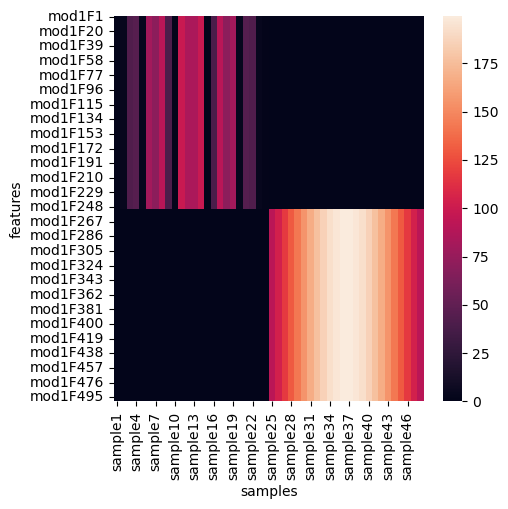

In [21]:
true_mod1, noisy_mod1, mf_mod1 = create_sim_data('mod1', n_timepoints=4, n_subjects=12, 
                                                 rank=2, C_=2e3)

#get half patients and half features
true_mod1_df_sub1 = true_mod1.to_dataframe().iloc[0:250,0:24]
true_mod1_df_sub2 = true_mod1.to_dataframe().iloc[0:250,24:48]
true_mod1_df_sub3 = true_mod1.to_dataframe().iloc[250:500,:]

#apply sine function to all rows
true_mod1_df_sub1 = 50*(1 + true_mod1_df_sub1.apply(np.sin, axis=1))

#now, concat all dataframes
mod1_df = pd.concat([true_mod1_df_sub1, true_mod1_df_sub2], axis=1)
mod1_df = pd.concat([mod1_df, true_mod1_df_sub3])
mod1_df = biom.Table(mod1_df.values, mod1_df.index, mod1_df.columns)

# plot data
plt.figure(figsize=(5, 5))
sns.heatmap(mod1_df.to_dataframe())
plt.xlabel('samples')
plt.ylabel('features')
plt.show()

In [22]:
#run joint-ctf
(mod1_subject_loads, mod1_feature_loads, 
mod1_state_loads, mod1_subject_lambdas,
mod1_var_explained, mod1_feature_covs) = joint_ctf(tables=[mod1_df],
                                                   sample_metadatas=[mf_mod1],
                                                   modality_ids=['mod1'],
                                                   individual_id_column='ind_id',
                                                   state_column='timepoint')
print(mod1_subject_lambdas)
print(mod1_var_explained.T)

Calculate components for component_1
Reached convergence in 2 iterations
Calculate components for component_2
Reached convergence in 6 iterations
Calculate components for component_3
Reached convergence in 7 iterations
       component_1   component_2  component_3
mod1  19908.777189  10363.050653  4458.335753
               component_1  component_2  component_3
var_explained     0.999639     0.000351     0.000011


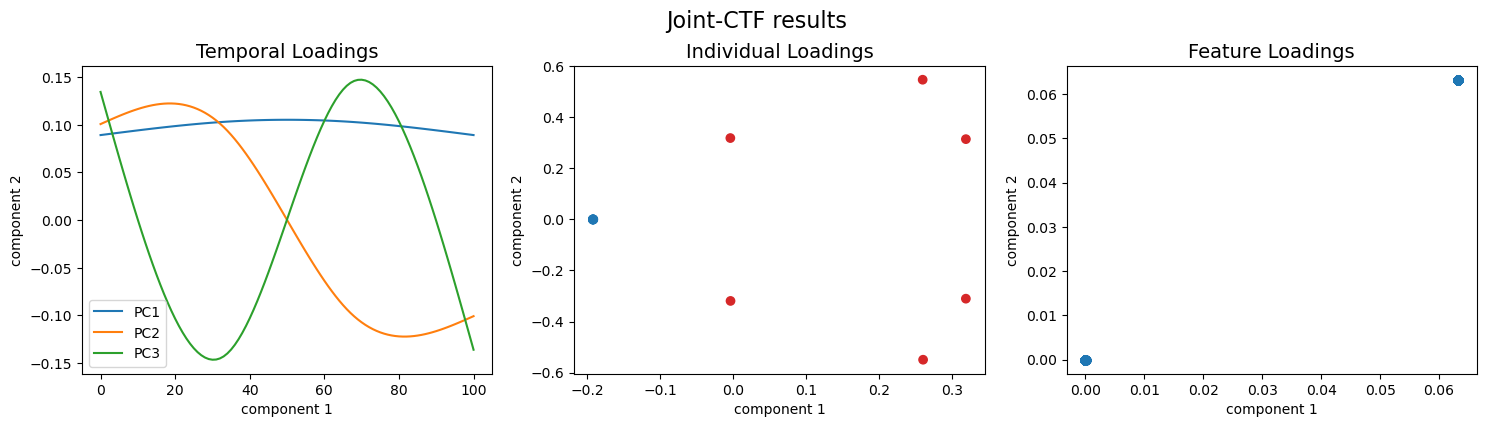

In [23]:
#visualize loadings
comp1 = 'component_1'
comp2 = 'component_2'
mf1 = mf_mod1.groupby('ind_id').agg({'group':'first'})
group_colors = {'group1': 'tab:red', 
                'group2': 'tab:blue',
                'group3': 'tab:green'}

fig, axn = plt.subplots(1, 3, figsize=(18, 4), sharey=False)
axn[0].plot(mod1_state_loads['mod1'][['component_1', 'component_2', 'component_3']], 
            label=['PC1', 'PC2', 'PC3'])
axn[0].set_title('Temporal Loadings', fontsize=14)
axn[0].legend()
axn[1].scatter(mod1_subject_loads['mod1'][comp1],
               mod1_subject_loads['mod1'][comp2],
               c=mf1['group'].map(group_colors))
axn[1].set_title('Individual Loadings', fontsize=14)
axn[2].scatter(mod1_feature_loads['mod1'][comp1],
               mod1_feature_loads['mod1'][comp2])
axn[2].set_title('Feature Loadings', fontsize=14)
plt.suptitle('Joint-CTF results', fontsize=16, y=1.02)
plt.setp(axn, xlabel=comp1.replace('_', ' '), 
         ylabel=comp2.replace('_', ' '))
plt.show()

### Test 2

One modality with sine, sigmoid, and constant noise patterns

/var/folders/wc/r9njmvn106j5gvr496l3xw65jl16p6/T/ipykernel_36240/3241581285.py:27: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[100.0, 0]'. Picking the first and converting the rest.
  mod2_df = pd.concat([mod1_df1, mod1_df2])
/var/folders/wc/r9njmvn106j5gvr496l3xw65jl16p6/T/ipykernel_36240/3241581285.py:28: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[100.0, 0]'. Picking the first and converting the rest.
  mod2_df = biom.Table(mod2_df.values, mod2_df.index, mod2_df.columns)


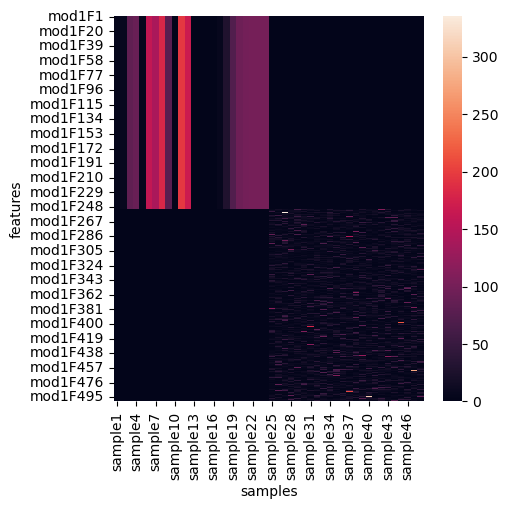

In [25]:
true_mod2, noisy_mod2, mf_mod2 = create_sim_data('mod1', n_timepoints=4, n_subjects=12, 
                                                 rank=2, C_=2e3)

#get half patients and half features
true_mod1_df_sub1 = true_mod2.to_dataframe().iloc[0:250,0:12]
true_mod1_df_sub2 = true_mod2.to_dataframe().iloc[0:250,12:24]
true_mod1_df_sub3 = true_mod2.to_dataframe().iloc[0:250,24:48]
true_mod1_df_sub4 = true_mod2.to_dataframe().iloc[250:500,0:24]
noisy_mod1_df_sub = noisy_mod2.to_dataframe().iloc[250:500,24:48]

#apply sine function to all rows
true_mod1_df_sub1 = 100*(1 + true_mod1_df_sub1.apply(np.sin, axis=1))
#apply sigmoid function to all rows
#true_mod1_df_sub2 = 100*true_mod1_df_sub2.apply(lambda x: (1/(1+np.exp(-x))), axis=1)
x = np.linspace(-10, 10, 12)
x = [1/(1+np.exp(-i)) for i in x]
#make all rows from true_mod1_df_sub2 equal to x
true_mod1_df_sub2 = 100*pd.DataFrame([x]*250, columns=true_mod1_df_sub2.columns,
                                     index=true_mod1_df_sub2.index)

#first half
mod1_df1 = pd.concat([true_mod1_df_sub1, true_mod1_df_sub2], axis=1)
mod1_df1 = pd.concat([mod1_df1, true_mod1_df_sub3], axis=1)
#second half
mod1_df2 = pd.concat([true_mod1_df_sub4, noisy_mod1_df_sub], axis=1)
#final concat
mod2_df = pd.concat([mod1_df1, mod1_df2])
mod2_df = biom.Table(mod2_df.values, mod2_df.index, mod2_df.columns)

# plot data
plt.figure(figsize=(5, 5))
sns.heatmap(mod2_df.to_dataframe())
plt.xlabel('samples')
plt.ylabel('features')
plt.show()

In [26]:
#run joint-ctf
(mod2_subject_loads, mod2_feature_loads, 
mod2_state_loads, mod2_subject_lambdas,
mod2_var_explained, mod2_feature_covs) = joint_ctf(tables=[mod2_df],
                                                   sample_metadatas=[mf_mod2],
                                                   modality_ids=['mod2'],
                                                   individual_id_column='ind_id',
                                                   state_column='timepoint')
print(mod2_subject_lambdas)
print(mod2_var_explained.T)

Calculate components for component_1
Reached convergence in 4 iterations
Calculate components for component_2
Reached convergence in 2 iterations
Calculate components for component_3
Reached convergence in 3 iterations
      component_1  component_2  component_3
mod2  15086.66139  8013.517173  4632.928266
               component_1  component_2  component_3
var_explained     0.952592     0.047374     0.000034


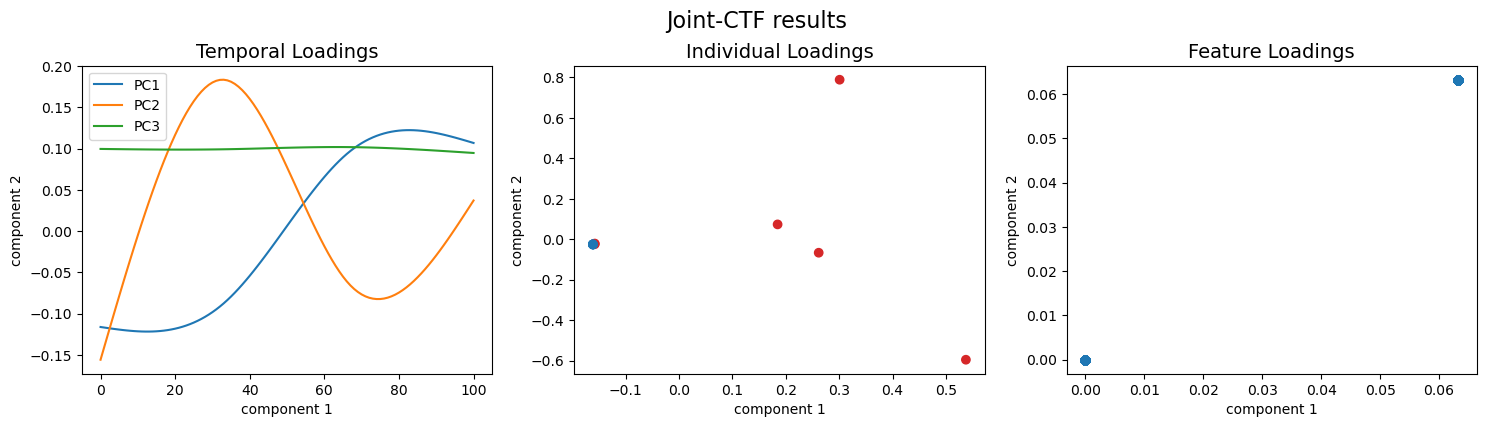

In [27]:
#visualize loadings
comp1 = 'component_1'
comp2 = 'component_2'
mf2 = mf_mod2.groupby('ind_id').agg({'group':'first'})
group_colors = {'group1': 'tab:red', 
                'group2': 'tab:blue',
                'group3': 'tab:green'}

fig, axn = plt.subplots(1, 3, figsize=(18, 4), sharey=False)
axn[0].plot(mod2_state_loads['mod2'][['component_1', 'component_2', 'component_3']], 
            label=['PC1', 'PC2', 'PC3'])
axn[0].set_title('Temporal Loadings', fontsize=14)
axn[0].legend()
axn[1].scatter(mod2_subject_loads['mod2'][comp1],
               mod2_subject_loads['mod2'][comp2],
               c=mf2['group'].map(group_colors))
axn[1].set_title('Individual Loadings', fontsize=14)
axn[2].scatter(mod2_feature_loads['mod2'][comp1],
               mod2_feature_loads['mod2'][comp2])
axn[2].set_title('Feature Loadings', fontsize=14)
plt.suptitle('Joint-CTF results', fontsize=16, y=1.02)
plt.setp(axn, xlabel=comp1.replace('_', ' '), 
         ylabel=comp2.replace('_', ' '))
plt.show()

/var/folders/wc/r9njmvn106j5gvr496l3xw65jl16p6/T/ipykernel_36240/1163798375.py:28: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[100.0, 0]'. Picking the first and converting the rest.
  mod2_df = pd.concat([mod1_df1, mod1_df2])
/var/folders/wc/r9njmvn106j5gvr496l3xw65jl16p6/T/ipykernel_36240/1163798375.py:28: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[0, 100.0]'. Picking the first and converting the rest.
  mod2_df = pd.concat([mod1_df1, mod1_df2])
/var/folders/wc/r9njmvn106j5gvr496l3xw65jl16p6/T/ipykernel_36240/1163798375.py:29: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[100.0, 0]'. Picking the first and converting the rest.
  mod2_df = biom.Table(mod2_df.values, mod2_df.index, mod2_df.columns)


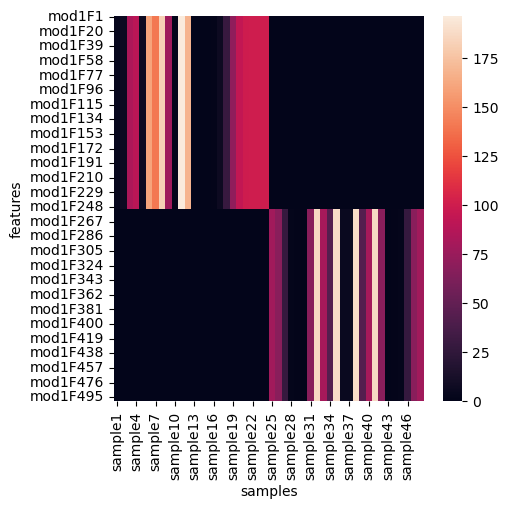

In [29]:
true_mod2, noisy_mod2, mf_mod2 = create_sim_data('mod1', n_timepoints=4, n_subjects=12, 
                                                 rank=2, C_=2e3)

#get half patients and half features
true_mod1_df_sub1 = true_mod2.to_dataframe().iloc[0:250,0:12]
true_mod1_df_sub2 = true_mod2.to_dataframe().iloc[0:250,12:24]
true_mod1_df_sub3 = true_mod2.to_dataframe().iloc[0:250,24:48]
true_mod1_df_sub4 = true_mod2.to_dataframe().iloc[250:500,0:24]
noisy_mod1_df_sub = true_mod2.to_dataframe().iloc[250:500,24:48]

#apply sine function to all rows
true_mod1_df_sub1 = 100*(1 + true_mod1_df_sub1.apply(np.sin, axis=1))
noisy_mod1_df_sub = 100*(1 + noisy_mod1_df_sub.apply(np.sin, axis=1))
#apply sigmoid function to all rows
#true_mod1_df_sub2 = 100*true_mod1_df_sub2.apply(lambda x: (1/(1+np.exp(-x))), axis=1)
x = np.linspace(-10, 10, 12)
x = [1/(1+np.exp(-i)) for i in x]
#make all rows from true_mod1_df_sub2 equal to x
true_mod1_df_sub2 = 100*pd.DataFrame([x]*250, columns=true_mod1_df_sub2.columns,
                                     index=true_mod1_df_sub2.index)

#first half
mod1_df1 = pd.concat([true_mod1_df_sub1, true_mod1_df_sub2], axis=1)
mod1_df1 = pd.concat([mod1_df1, true_mod1_df_sub3], axis=1)
#second half
mod1_df2 = pd.concat([true_mod1_df_sub4, noisy_mod1_df_sub], axis=1)
#final concat
mod2_df = pd.concat([mod1_df1, mod1_df2])
mod2_df = biom.Table(mod2_df.values, mod2_df.index, mod2_df.columns)

# plot data
plt.figure(figsize=(5, 5))
sns.heatmap(mod2_df.to_dataframe())
plt.xlabel('samples')
plt.ylabel('features')
plt.show()

In [30]:
#run joint-ctf
(mod2_subject_loads, mod2_feature_loads, 
mod2_state_loads, mod2_subject_lambdas,
mod2_var_explained, mod2_feature_covs) = joint_ctf(tables=[mod2_df],
                                                   sample_metadatas=[mf_mod2],
                                                   modality_ids=['mod2'],
                                                   individual_id_column='ind_id',
                                                   state_column='timepoint')
print(mod2_subject_lambdas)
print(mod2_var_explained.T)

Calculate components for component_1
Reached convergence in 3 iterations
Calculate components for component_2
Reached convergence in 12 iterations
Calculate components for component_3
Reached convergence in 4 iterations
       component_1   component_2   component_3
mod2  26265.199131  15086.617322  12602.531186
               component_1  component_2  component_3
var_explained     0.999826     0.000152     0.000022


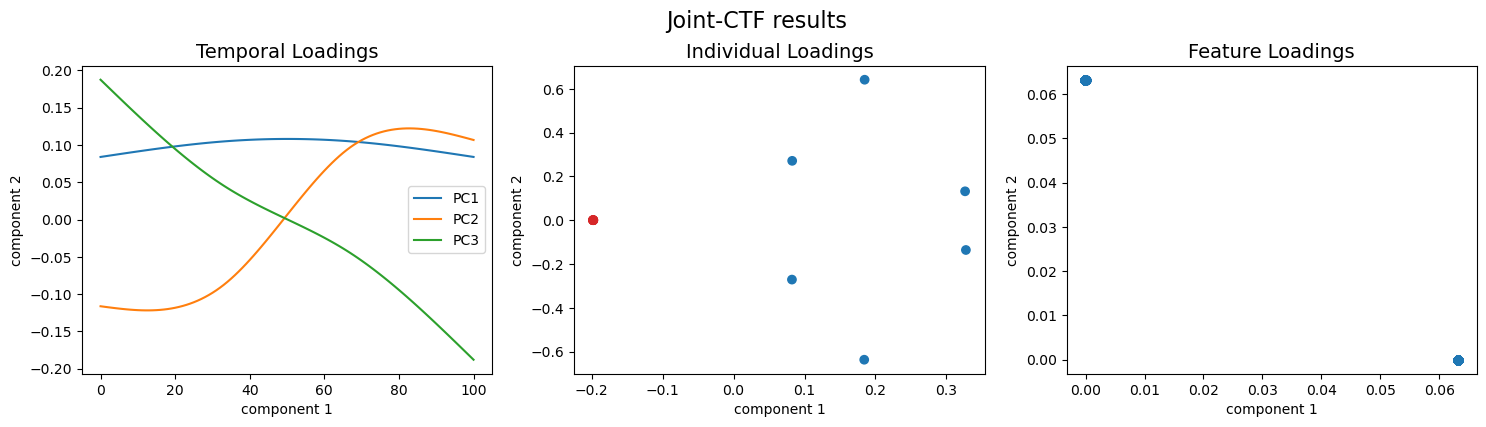

In [31]:
#visualize loadings
comp1 = 'component_1'
comp2 = 'component_2'
mf2 = mf_mod2.groupby('ind_id').agg({'group':'first'})
group_colors = {'group1': 'tab:red', 
                'group2': 'tab:blue',
                'group3': 'tab:green'}

fig, axn = plt.subplots(1, 3, figsize=(18, 4), sharey=False)
axn[0].plot(mod2_state_loads['mod2'][['component_1', 'component_2', 'component_3']], 
            label=['PC1', 'PC2', 'PC3'])
axn[0].set_title('Temporal Loadings', fontsize=14)
axn[0].legend()
axn[1].scatter(mod2_subject_loads['mod2'][comp1],
               mod2_subject_loads['mod2'][comp2],
               c=mf2['group'].map(group_colors))
axn[1].set_title('Individual Loadings', fontsize=14)
axn[2].scatter(mod2_feature_loads['mod2'][comp1],
               mod2_feature_loads['mod2'][comp2])
axn[2].set_title('Feature Loadings', fontsize=14)
plt.suptitle('Joint-CTF results', fontsize=16, y=1.02)
plt.setp(axn, xlabel=comp1.replace('_', ' '), 
         ylabel=comp2.replace('_', ' '))
plt.show()

### Test 3

Two modalities:
- Mod1: sine + constant noise
- Mod2: Sigma + constant noise

In [42]:
true_mod1, noisy_mod1, mf_mod1 = create_sim_data('mod1', n_timepoints=4, n_subjects=12, 
                                                 rank=2, C_=2e3)

#get half patients and half features
true_mod1_df_sub1 = true_mod1.to_dataframe().iloc[0:250,0:24]
true_mod1_df_sub2 = true_mod1.to_dataframe().iloc[0:250,24:48]
true_mod1_df_sub3 = true_mod1.to_dataframe().iloc[250:500,0:24]
noisy_mod1_df_sub1 = noisy_mod1.to_dataframe().iloc[250:500,24:48]

#apply sine function to all rows
true_mod1_df_sub1 = 50*(1 + true_mod1_df_sub1.apply(np.sin, axis=1))

#now, concat all dataframes
mod1_df = pd.concat([true_mod1_df_sub1, true_mod1_df_sub2], axis=1)
noisy_mod1_df_sub = pd.concat([true_mod1_df_sub3, noisy_mod1_df_sub1], axis=1)
mod1_df = pd.concat([mod1_df, noisy_mod1_df_sub])
mod1_df = biom.Table(mod1_df.values, mod1_df.index, mod1_df.columns)

/var/folders/wc/r9njmvn106j5gvr496l3xw65jl16p6/T/ipykernel_36240/492003796.py:16: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[50.0, 0]'. Picking the first and converting the rest.
  mod1_df = pd.concat([mod1_df, noisy_mod1_df_sub])
/var/folders/wc/r9njmvn106j5gvr496l3xw65jl16p6/T/ipykernel_36240/492003796.py:17: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[50.0, 0]'. Picking the first and converting the rest.
  mod1_df = biom.Table(mod1_df.values, mod1_df.index, mod1_df.columns)


In [43]:
true_mod2, noisy_mod2, mf_mod2 = create_sim_data('mod1', n_timepoints=4, n_subjects=12, 
                                                 rank=2, C_=2e3)

#get half patients and half features
true_mod1_df_sub1 = true_mod2.to_dataframe().iloc[0:250,0:24]
true_mod1_df_sub2 = true_mod2.to_dataframe().iloc[0:250,24:48]
noisy_mod2 = noisy_mod2.to_dataframe().iloc[250:500,0:48]

#apply sigmoid function to all rows
x = np.linspace(-10, 10, 24)
x = [1/(1+np.exp(-i)) for i in x]
#make all rows from true_mod1_df_sub1 equal to x
true_mod1_df_sub1 = 110*pd.DataFrame([x]*250, columns=true_mod1_df_sub1.columns,
                                     index=true_mod1_df_sub1.index)

#first half
mod2_df = pd.concat([true_mod1_df_sub1, true_mod1_df_sub2], axis=1)
#final concat
mod2_df = pd.concat([mod2_df, noisy_mod2])
mod2_df = biom.Table(mod2_df.values, mod2_df.index, mod2_df.columns)

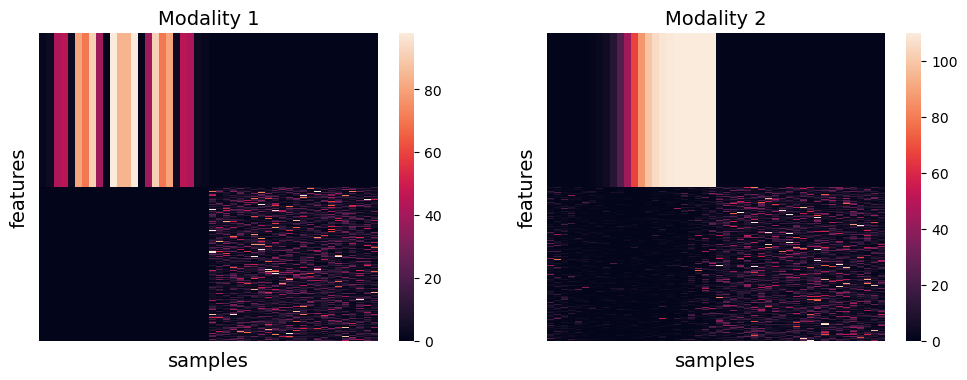

In [45]:
# plot data
fig, axn = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(mod1_df.matrix_data.toarray(), robust=True, 
            ax=axn[0], xticklabels=False, yticklabels=False)
sns.heatmap(mod2_df.matrix_data.toarray(), robust=True, 
            ax=axn[1], xticklabels=False, yticklabels=False)
axn[0].set_ylabel('features', color='black', fontsize=14)
axn[0].set_xlabel('samples', color='black', fontsize=14)
axn[0].set_title('Modality 1', color='black', fontsize=14)
axn[1].set_ylabel('features', color='black', fontsize=14)
axn[1].set_xlabel('samples', color='black', fontsize=14)
axn[1].set_title('Modality 2', color='black', fontsize=14)
plt.show()

In [38]:
#run joint-ctf
(subject_loads, feature_loads, state_loads,
evals, var_explained, feature_covs) = joint_ctf(tables=[mod1_df, mod2_df],
                                                sample_metadatas=[mf_mod1, mf_mod2],
                                                modality_ids=['mod1', 'mod2'],
                                                individual_id_column='ind_id',
                                                state_column='timepoint')
print(evals)
print(var_explained.T)

Calculate components for component_1
Reached convergence in 6 iterations
Calculate components for component_2
Reached convergence in 12 iterations
Calculate components for component_3
Reached convergence in 17 iterations
       component_1  component_2  component_3
mod1  10343.960421  4675.063735  4465.031650
mod2   4584.234468   637.287957   334.118636
               component_1  component_2  component_3
var_explained     0.723068     0.210013     0.066919


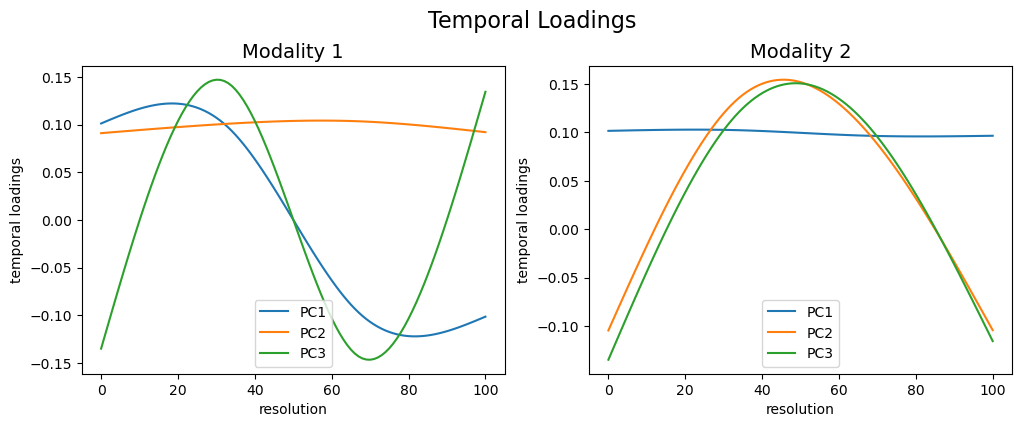

In [54]:
#temporal loadings
fig, axn = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
axn[0].plot(state_loads['mod1'][['component_1', 'component_2', 'component_3']], 
            label=['PC1', 'PC2', 'PC3'])
axn[0].legend()
axn[0].set_title('Modality 1', fontsize=14)
axn[1].plot(state_loads['mod2'][['component_1', 'component_2', 'component_3']],
            label=['PC1', 'PC2', 'PC3'])
axn[1].legend()
axn[1].set_title('Modality 2', fontsize=14)
plt.suptitle('Temporal Loadings', fontsize=16, y=1.02)
plt.setp(axn, xlabel='resolution', ylabel='temporal loadings')
plt.show()

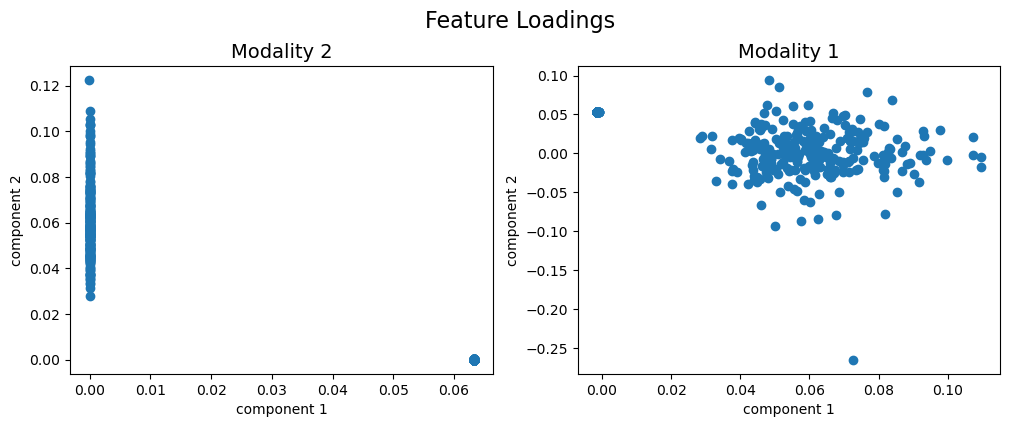

In [53]:
#individual loadings
comp1 = 'component_1'
comp2 = 'component_2'

fig, axn = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
axn[0].scatter(feature_loads['mod1'][comp1],
               feature_loads['mod1'][comp2])
axn[0].set_title('Modality 2', fontsize=14)
axn[1].scatter(feature_loads['mod2'][comp1],
               feature_loads['mod2'][comp2])
axn[1].set_title('Modality 1', fontsize=14)
plt.suptitle('Feature Loadings', fontsize=16, y=1.02)
plt.setp(axn, xlabel=comp1.replace('_', ' '), 
         ylabel=comp2.replace('_', ' '))
plt.show()

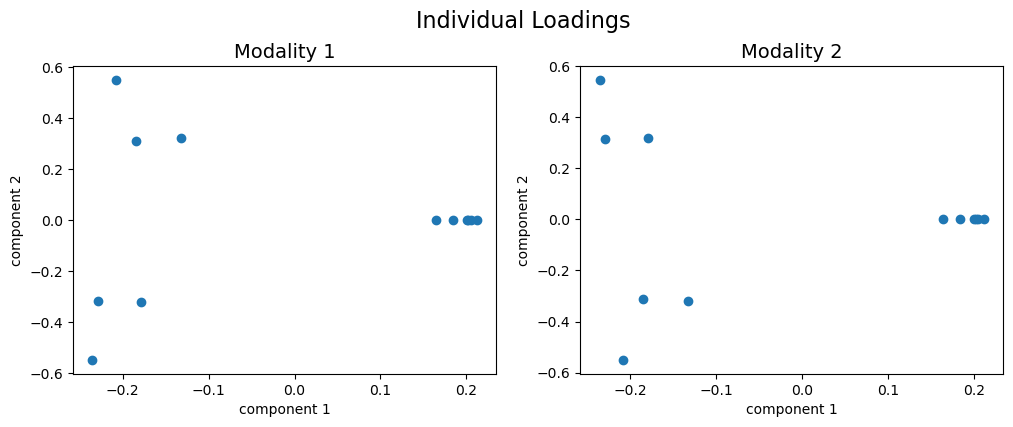

In [52]:
#individual loadings
comp1 = 'component_1'
comp2 = 'component_2'

fig, axn = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
axn[0].scatter(subject_loads['mod1'][comp1],
               subject_loads['mod1'][comp2])
axn[0].set_title('Modality 1', fontsize=14)
axn[1].scatter(subject_loads['mod2'][comp1],
               subject_loads['mod2'][comp2])
axn[1].set_title('Modality 2', fontsize=14)
plt.suptitle('Individual Loadings', fontsize=16, y=1.02)
plt.setp(axn, xlabel=comp1.replace('_', ' '), 
         ylabel=comp2.replace('_', ' '))
plt.show()